# (Try to) identify signals of gentrification from Airbnb data

In [3]:
import os
import re

import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from scipy.stats import zscore, gaussian_kde

from datetime import datetime

import seaborn as sns

from shapely.geometry import Point
from geopandas import GeoDataFrame

from IPython.core.pylabtools import figsize
from fontTools.varLib.interpolatableHelpers import matching_for_vectors
#from pygments.lexers.textfmts import TodotxtLexer
from together import Together  # pip install together

# from statsmodels.stats.inter_rater import fleiss_kappa

from Functions import *

### Running for Bristol 

For Bristol there should be 1495 rows in the results. There are 2644 rows in the original listings file, but 1149 of them have no description for the neighbourhood overview or 

In [103]:
city='bristol'
neighbourhoods = gpd.read_file(f"../data/airbnb-{city}/neighbourhoods.geojson")
lsoas =  gpd.read_file('../data/Bristol_LSOAs/Lower_Layer_Super_Output_Areas_2011_(Precise).shp')

In [10]:
base_dir = os.path.expanduser(f"../data/airbnb-{city}/")
gentrication_cat_df = pd.read_csv(base_dir + 'airbnb_gentrification_scores_categorical_01.csv')
gentrication_df = pd.read_csv(base_dir + 'airbnb_gentrification_scores_newprompt_completelistings_01.csv')
niceness_df = pd.read_csv(base_dir + 'airbnb_gentrification_scores_niceness_completelistings_01.csv')

In [24]:
overall_df = gentrication_cat_df
overall_df['niceness_score'] = niceness_df['gentrification_prediction']
overall_df['niceness_explanation'] = niceness_df['explanation']
overall_df['gentrification_num_score'] = gentrication_df['gentrification_prediction']
overall_df['gentrification_num_explanation'] = gentrication_df['explanation']

In [25]:
# 1. Create a GeoDataFrame from your overall_df (assumed to be in WGS84)
overall_df['geometry'] = overall_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
overall_gdf = gpd.GeoDataFrame(overall_df, geometry='geometry', crs="EPSG:4326")

# 2. Reproject the overall_gdf to match the LSOA CRS (for example, British National Grid EPSG:27700)
overall_gdf = overall_gdf.to_crs(lsoas.crs)

# 3. Perform a spatial join (using the 'within' predicate) to find which LSOA each point falls into.
# Replace 'LSOA_NAME' with the name of the column in lsoa_gdf that contains the LSOA identifier.
overall_gdf = gpd.sjoin(overall_gdf, lsoas[['LSOA11NM', 'geometry']], how='left', predicate='within')

### Remove:
- NaN values

In [8]:
# print(len(df))
# df = df[df['gentrification_prediction'].notna()].copy()
# print(len(df))

### Add:
- Column for the length of the text given to the model
- Column for the relative price of the listing

In [26]:
overall_gdf['overview_length'] = overall_gdf['text'].apply(lambda x: len(str(x)) if x else 0)
overall_gdf = add_relative_price(overall_gdf)
# df['room_type_code'] = pd.factorize(df['room_type'])[0] + 1

In [27]:
mapping = {'Na': 0,'Undeveloped': 1, 'Emerging': 2, 'Gentrifying': 3, 'Established': 4}
overall_gdf['gentrification_prediction_code'] = overall_gdf['gentrification_prediction'].map(mapping)

In [104]:
# neighbourhoods_scores_gentrification = overall_gdf.groupby("LSOA11NM")["gentrification_prediction_code"].agg(lambda x: pd.Series.mode(x).tolist())
# neighbourhoods_scores_num_gentrification = overall_gdf.groupby("LSOA11NM")["gentrification_num_score"].agg(lambda x: pd.Series.mode(x).tolist())
# neighbourhoods_scores_niceness = overall_gdf.groupby("LSOA11NM")["niceness_score"].agg(lambda x: pd.Series.mode(x).tolist())

neighbourhoods_scores_gentrification = overall_gdf.groupby("LSOA11NM")["gentrification_prediction_code"].agg(lambda x: pd.Series.mode(x).iloc[0])
neighbourhoods_scores_num_gentrification = overall_gdf.groupby("LSOA11NM")["gentrification_num_score"].agg(
    lambda x: pd.Series.mode(x).iloc[0] if not pd.Series.mode(x).empty else np.nan)
neighbourhoods_scores_niceness = overall_gdf.groupby("LSOA11NM")["niceness_score"].agg(
    lambda x: pd.Series.mode(x).iloc[0] if not pd.Series.mode(x).empty else np.nan)

# neighbourhoods = neighbourhoods.sort_values(by='neighbourhood')
# neighbourhoods['gentrification_prediction'] = np.array(neighbourhoods_scores_gentrification)
# neighbourhoods['niceness_score'] = np.array(neighbourhoods_scores_niceness)
# neighbourhoods['gentrification_num_prediction'] = np.array(neighbourhoods_scores_num_gentrification

lsoas = lsoas.sort_values(by='LSOA11NM')

lsoas = lsoas.merge(neighbourhoods_scores_gentrification, on='LSOA11NM', how='left')
lsoas = lsoas.merge(neighbourhoods_scores_niceness, on='LSOA11NM', how='left')
lsoas = lsoas.merge(neighbourhoods_scores_num_gentrification, on='LSOA11NM', how='left')

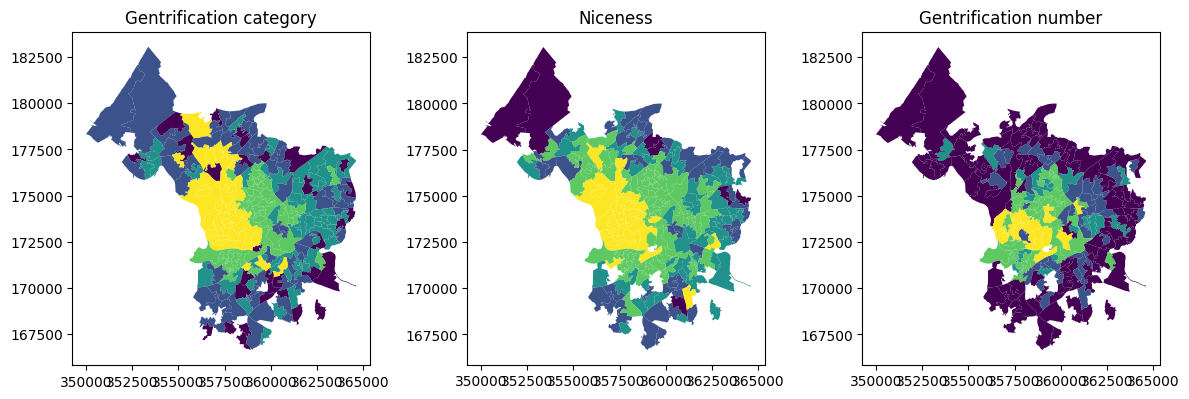

In [106]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))

lsoas.plot(ax=axs[0], column='gentrification_prediction_code')
axs[0].set_title("Gentrification category")

lsoas.plot(ax=axs[1], column='niceness_score')
axs[1].set_title("Niceness")

lsoas.plot(ax=axs[2], column='gentrification_num_score')
axs[2].set_title("Gentrification number")

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [351]:
indicators = pd.read_csv("../data/SocioEconomicData/Eng_imputedV3.csv")
indicators_bristol = indicators[indicators['LA_NAME'] =='Bristol, City of'].copy()

In [352]:
indicators_bristol = indicators_bristol.rename(columns={"LSOA": 'LSOA11CD'})
indicators_bristol = indicators_bristol.merge(lsoas[['LSOA11CD', 'gentrification_prediction_code']], on='LSOA11CD', how='left')

### Rescale values between 0 and 1

In [353]:
numeric_cols = indicators_bristol.columns
numeric_cols = numeric_cols.drop(['LSOA11CD', 'LA_NAME', 'gentrification_prediction_code'])
indicators_bristol[numeric_cols] = (indicators_bristol[numeric_cols] - indicators_bristol[numeric_cols].min()) / \
                                   (indicators_bristol[numeric_cols].max() - indicators_bristol[numeric_cols].min())

In [354]:
indicators_bristol.sort_values(by='gentrification_prediction_code', inplace=True)

### Plot for one LSOA

In [ ]:
E01014485 = indicators_bristol[indicators_bristol['LSOA'] == "E01014485"]
del E01014485['LSOA']
del E01014485['LA_NAME']
E01014485_T = E01014485.T
E01014485_T.reset_index(inplace=True)
E01014485_T = E01014485_T.rename(columns={14052: 'scores'})
# E01014485_T['max_vals'] = max_vals[0].values
df = E01014485_T.copy()
# df['pct'] = df['scores'] / df['max_vals']
df = df.set_index('index')

# Replace NaN values with 0 in the plot data (but keep NaNs in the DataFrame)
df['scores_for_plot'] = df['scores'].fillna(0)

# Recalculate N and angles after replacing NaNs
N = df.shape[0]
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)


In [343]:
# class_data = indicators_bristol[indicators_bristol['gentrification_prediction_code'] == gentr_class]
# class_data = class_data.set_index('LSOA11CD')
# class_data_plot = class_data.drop(columns=[ 'LA_NAME', 'gentrification_prediction_code'])
# class_data_T = class_data_plot.T
# # class_data_T.reset_index(inplace=True)
# # class_data_T = class_data_T.rename(columns={class_data_T.columns[0]: 'scores'})
# class_data_T 
# # # Set the index to the indicator names
# # df = class_data_T.set_index('index')

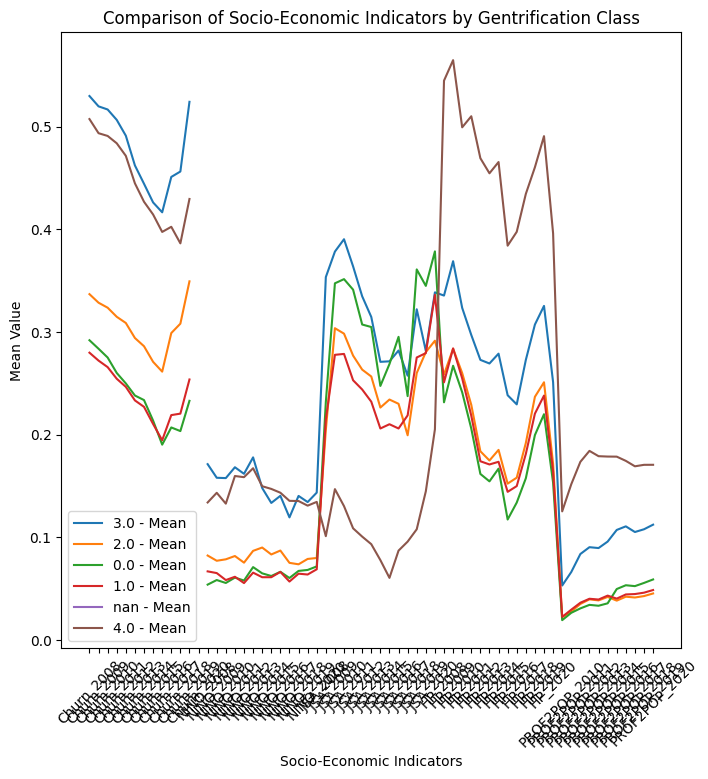

In [355]:
# Create a figure for mean comparison
plt.figure(figsize=(8, 8))

# Loop over each gentrification class
for gentr_class in gentrification_classes:
    # Filter the data for this gentrification class
    class_data = indicators_bristol[indicators_bristol['gentrification_prediction_code'] == gentr_class]
    
    # Drop unnecessary columns
    class_data_plot = class_data.drop(columns=['LSOA11CD', 'LA_NAME', 'gentrification_prediction_code'])
    
    # Calculate mean scores for each indicator
    mean_scores = class_data_plot.mean()


    # Plot the mean values for this gentrification class
    plt.plot(mean_scores.index, mean_scores.values, label=f'{gentr_class} - Mean')

plt.title('Comparison of Socio-Economic Indicators by Gentrification Class')
plt.xlabel('Socio-Economic Indicators')
plt.ylabel('Mean Value')
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Create a figure for mean comparison
plt.figure(figsize=(8, 8))

# Loop over each gentrification class
for gentr_class in gentrification_classes:
    # Filter the data for this gentrification class
    class_data = indicators_bristol[indicators_bristol['gentrification_prediction_code'] == gentr_class]
    
    # Drop unnecessary columns
    class_data_plot = class_data.drop(columns=['LSOA11CD', 'LA_NAME', 'gentrification_prediction_code'])
    
    # Calculate mean scores for each indicator
    mean_scores = class_data_plot.mean()


    # Plot the mean values for this gentrification class
    plt.plot(mean_scores.index, mean_scores.values, label=f'{gentr_class} - Mean')

plt.title('Comparison of Socio-Economic Indicators by Gentrification Class')
plt.xlabel('Socio-Economic Indicators')
plt.ylabel('Mean Value')
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [357]:
# # Group LSOAs by gentrification class
# gentrification_classes = indicators_bristol['gentrification_prediction_code'].unique()

# # Create a figure
# plt.figure(figsize=(10, 10))

# # Loop over each gentrification class and plot the overlay
# for gentr_class in gentrification_classes:
#     # Filter the data for this gentrification class
#     class_data = indicators_bristol[indicators_bristol['gentrification_prediction_code'] == gentr_class]
    
#     # Drop unnecessary columns for plotting
#     class_data_plot = class_data.drop(columns=['LSOA11CD', 'LA_NAME', 'gentrification_prediction_code'])
    
#     # Transpose the data to get indicators as rows
#     class_data_T = class_data_plot.T
#     class_data_T.reset_index(inplace=True)
    
#     # The first column after reset_index() will be named 'index', which contains the indicator names
#     class_data_T = class_data_T.rename(columns={class_data_T.columns[0]: 'scores'})
    
#     # Set the index to the indicator names
#     # df = class_data_T.set_index('index')

#     # Calculate mean and standard deviation of scores
#     mean_scores = df['scores'].mean()
#     std_scores = df['scores'].std()

#     # Recalculate angles for radar plot
#     N = df.shape[0]
#     theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
    
#     # Create a subplot for the polar plot
#     ax = plt.subplot(111, polar=True)

#     # Plot all individual LSOAs in this class
#     for _, row in class_data_T.iterrows():
#         ax.bar(theta, row['scores'], width=2 * np.pi / N, linewidth=1, edgecolor='k', alpha=0.3)

#     # Plot the mean with a thicker line
#     ax.plot(theta, [mean_scores] * N, linewidth=3, color='r', label=f'Class {gentr_class} - Mean')

#     # Add a shaded area around the mean (standard deviation range)
#     ax.fill(theta, [mean_scores + std_scores] * N, color='r', alpha=0.2)
#     ax.fill(theta, [mean_scores - std_scores] * N, color='r', alpha=0.2)

# # Add labels
# ax.set_xticks(theta)
# ax.set_xticklabels(df.index, fontsize=8, rotation=45)
# ax.set_yticklabels([])

# plt.title('Socio-Economic Indicator Comparison by Gentrification Class')
# plt.legend()
# plt.show()


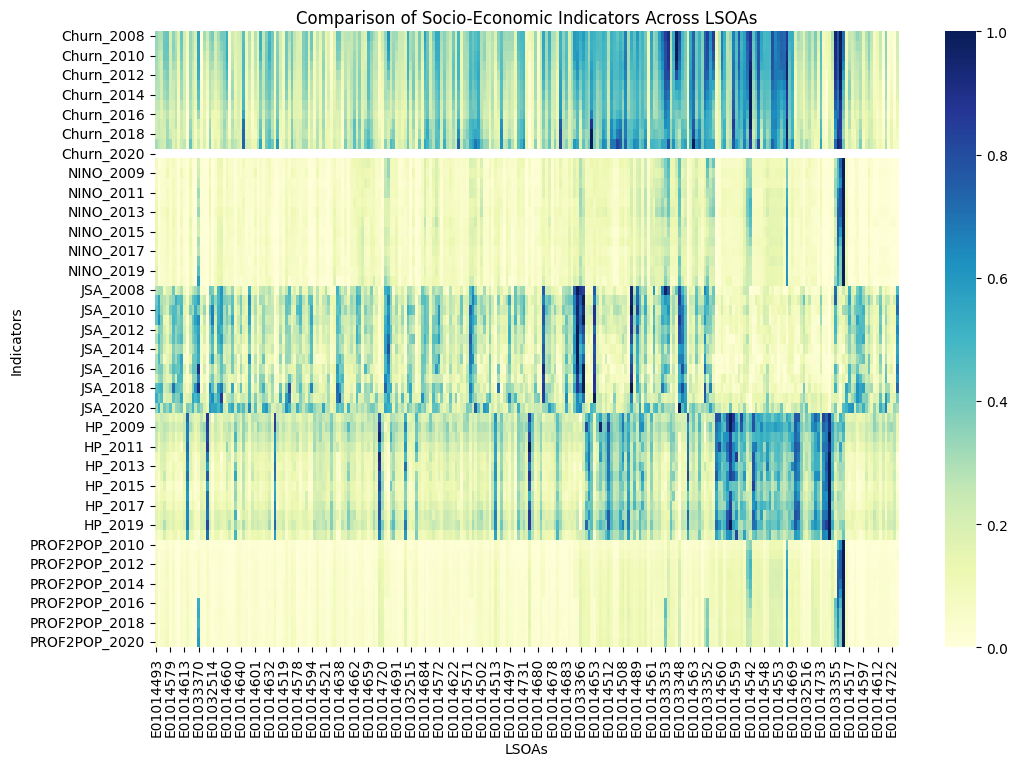

In [298]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure your DataFrame is in the correct shape (LSOAs as rows, indicators as columns)
df_comparison = indicators_bristol.set_index(['LSOA11CD']).drop(columns=['LA_NAME', 'gentrification_prediction_code'])

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_comparison.T, cmap="YlGnBu", annot=False, fmt='.2f', cbar=True)
plt.title('Comparison of Socio-Economic Indicators Across LSOAs')
plt.ylabel('Indicators')
plt.xlabel('LSOAs')
plt.show()


In [390]:
def plot_rose(ax, lsoa_code):
    this_lsoa = indicators_bristol[indicators_bristol['LSOA11CD'] == lsoa_code]
    this_lsoa.reset_index(inplace=True, drop=True)
    del this_lsoa['LSOA11CD']
    del this_lsoa['LA_NAME']
    del this_lsoa['gentrification_prediction_code']
    this_lsoa_T = this_lsoa.T
    this_lsoa_T.reset_index(inplace=True)
    this_lsoa_T = this_lsoa_T.rename(columns={0: 'scores'})
    # E01014485_T['max_vals'] = max_vals[0].values
    df = this_lsoa_T.copy()
    # df['pct'] = df['scores'] / df['max_vals']
    df = df.set_index('index')
    
    # Replace NaN values with 0 in the plot data (but keep NaNs in the DataFrame)
    df['scores_for_plot'] = df['scores'].fillna(0)
    
    # Recalculate N and angles after replacing NaNs
    N = df.shape[0]
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
    
    # Assign new angles
    df['radar_angles'] = theta
    
    # Plot
    ax.bar(df['radar_angles'], df['scores_for_plot'], width=2 * np.pi / N, linewidth=2, edgecolor='k', alpha=0.5)
    
    # Adjust labels (keeping original categories with NaNs)
    ax.set_xticks(theta)
    ax.set_xticklabels(df.index)
    ax.set_yticklabels([])
    
    # Avoid plotting NaN values as lines (since scores_for_plot is 0 where NaN)
    #plt.show()


46


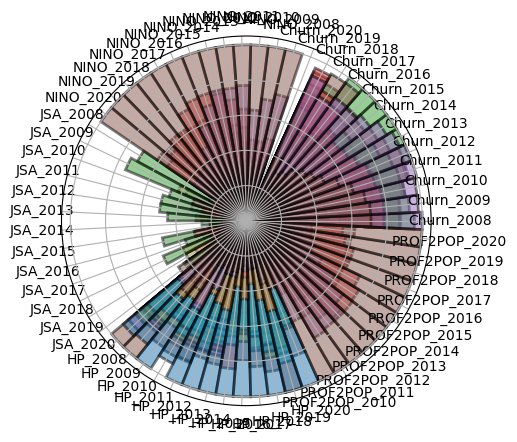

In [408]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
# Loop over each gentrification class
for gentr_class in [4]:
    # Filter the data for this gentrification class
    class_data = indicators_bristol[indicators_bristol['gentrification_prediction_code'] == gentr_class]
    print(len(class_data))
    # Drop unnecessary columns
    # class_data_plot = class_data.drop(columns=['LSOA11CD', 'LA_NAME', 'gentrification_prediction_code'])
    
    for lsoa in class_data['LSOA11CD']:
        plot_rose(ax, lsoa)



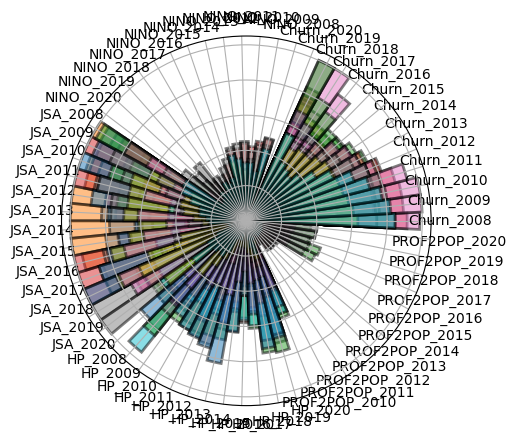

In [406]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
# Loop over each gentrification class
for gentr_class in [3]:
    # Filter the data for this gentrification class
    class_data = indicators_bristol[indicators_bristol['gentrification_prediction_code'] == gentr_class]
    print(len(class_data))
    # Drop unnecessary columns
    # class_data_plot = class_data.drop(columns=['LSOA11CD', 'LA_NAME', 'gentrification_prediction_code'])
    
    for lsoa in class_data['LSOA11CD']:
        plot_rose(ax, lsoa)



61


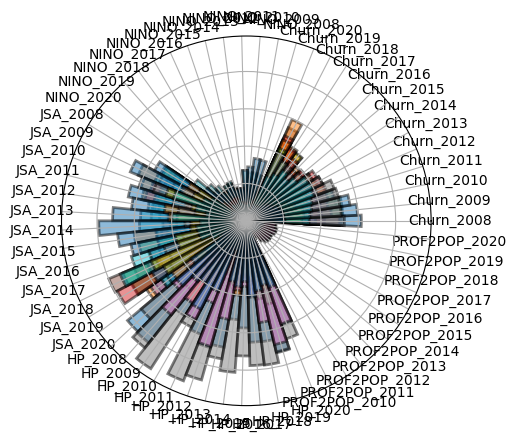

In [409]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
# Loop over each gentrification class
for gentr_class in [1]:
    # Filter the data for this gentrification class
    class_data = indicators_bristol[indicators_bristol['gentrification_prediction_code'] == gentr_class]
    print(len(class_data))
    # Drop unnecessary columns
    # class_data_plot = class_data.drop(columns=['LSOA11CD', 'LA_NAME', 'gentrification_prediction_code'])
    
    for lsoa in class_data['LSOA11CD']:
        plot_rose(ax, lsoa)



## Map the scores, colouring by gentrification prediction

In [18]:
# moving_map = map_not_static(neighbourhoods, overall_df, 'gentrification_prediction_code', True)
# display(moving_map)

In [76]:
# moving_map = map_not_static(neighbourhoods, overall_df, 'gentrification_prediction', True)
# display(moving_map)

### Look at correlation between listing length and score

In [ ]:
make_scatter_plot(df, 'overview_length')

In [ ]:
make_scatter_plot(df, 'price_relative')

In [124]:
import pandas as pd
from textblob import TextBlob
import re

# Define weighted keywords
keyword_map = {
    # High Gentrification Indicators (+3)
    "up-and-coming": 3, "revitalized": 3, "urban renewal": 3, "trendy": 3,
    "boutique stores": 3, "artisan coffee": 3, "craft brewery": 3, 
    "farm-to-table": 3, "luxury loft": 3, "co-working spaces": 3, "renovated": 3,

    # Moderate Gentrification Indicators (+2)
    "cultural hub": 2, "hip": 2, "eco-conscious": 2, "vibrant art scene": 2,
    "independent shops": 2, "local farmers market": 2, "food trucks": 2, 
    "community events": 2, "pop-up shops": 2, "speakeasy": 2, "converted warehouse": 2,

    # Subtle/Early Indicators (+1)
    "authentic": 1, "diverse": 1, "hidden gem": 1, "off the beaten path": 1,
    "family-friendly": 1, "walkable": 1, "green spaces": 1, "pet-friendly": 1,
    "friendly neighbors": 1, "historic charm": 1, "safe neighborhood": 1
}

def analyze_listing(text):
    text=str(text)
    # Handle NaN or non-string inputs
    if not isinstance(text, str):
        print("not text")
        return pd.Series([0, 0, 0, []])  # No score, neutral sentiment, empty keyword list

    text_lower = text.lower()
    score = 0
    keywords_found = []

    # Check for keywords
    for keyword, weight in keyword_map.items():
        if re.search(r'\b' + re.escape(keyword) + r'\b', text_lower):
            score += weight
            keywords_found.append(keyword)
    print(keywords_found)
    # Sentiment Analysis
    sentiment = TextBlob(text).sentiment.polarity  # Range from -1 to 1
    sentiment_modifier = 1 if sentiment > 0 else -1 if sentiment < 0 else 0
    adjusted_score = score + sentiment_modifier

    return pd.Series([score, sentiment, adjusted_score, keywords_found])

# Apply analysis to DataFrame
overall_df[['Keyword_Score', 'Sentiment', 'Final_Score', 'Keywords_Found']] = overall_df['text'].apply(analyze_listing)



[]
[]
['hip', 'independent shops', 'green spaces']
['green spaces']
[]
['independent shops']
[]
[]
[]
[]
[]
[]
[]
[]
['independent shops', 'family-friendly']
[]
[]
[]
[]
[]
[]
[]
['independent shops']
[]
[]
['cultural hub']
['hip', 'authentic']
[]
[]
['independent shops']
['independent shops']
['trendy', 'diverse', 'green spaces']
[]
[]
['diverse']
[]
[]
['diverse']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['diverse']
[]
[]
[]
[]
['trendy', 'independent shops']
['independent shops']
[]
[]
['independent shops']
['community events']
[]
['independent shops']
[]
[]
[]
[]
[]
[]
[]
['independent shops']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['independent shops']
['trendy']
[]
[]
[]
[]
['diverse']
[]
[]
['independent shops']
[]
[]
[]
[]
['independent shops']
[]
[]
[]
[]
[]
[]
['independent shops']
[]
[]
[]
[]
[]
['hip']
[]
[]
[]
['renovated']
[]
[]
[]
[]
[]
[]
['independent shops']
[]
[]
[]
[]
[]
['independent shops']
[]
[]
[]
[]
[]
['independent shops']
[]
[]
[]
[]
['independent shops', 'green spaces']
[